In [13]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [22]:
actions = [
    'ice',
    'americano'
]

data = np.concatenate([
    np.load('./seq_ice.npy'),
    np.load('./seq_americano.npy')
], axis=0)

data.shape

FileNotFoundError: [Errno 2] No such file or directory: './seq_ice.npy'

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3239, 30, 99)
(3239,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3239, 4)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2915, 30, 99) (2915, 4)
(324, 30, 99) (324, 4)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

c:\Users\GJ\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,196 (172.64 KB)

 Trainable params: 44,196 (172.64 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5166 - loss: 19.1324
Epoch 1: val_acc improved from -inf to 0.85494, saving model to models/model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5203 - loss: 18.7494 - val_acc: 0.8549 - val_loss: 1.2543 - learning_rate: 0.0010
Epoch 2/200
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7095 - loss: 8.0140
Epoch 2: val_acc did not improve from 0.85494
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6957 - loss: 8.5079 - val_acc: 0.6636 - val_loss: 3.5445 - learning_rate: 0.0010
Epoch 3/200
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7223 - loss: 2.9972
Epoch 3: val_acc did not improve from 0.85494
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.7229 - loss: 2.9828 - val_acc: 0.5463 - val_loss: 2.8908 - learning_rate: 0.0010
Epoch 4/200
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7962 - loss: 2.0337
Epoch 4: val_acc did not improve from 0.85494
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7973 - loss: 2.0188 

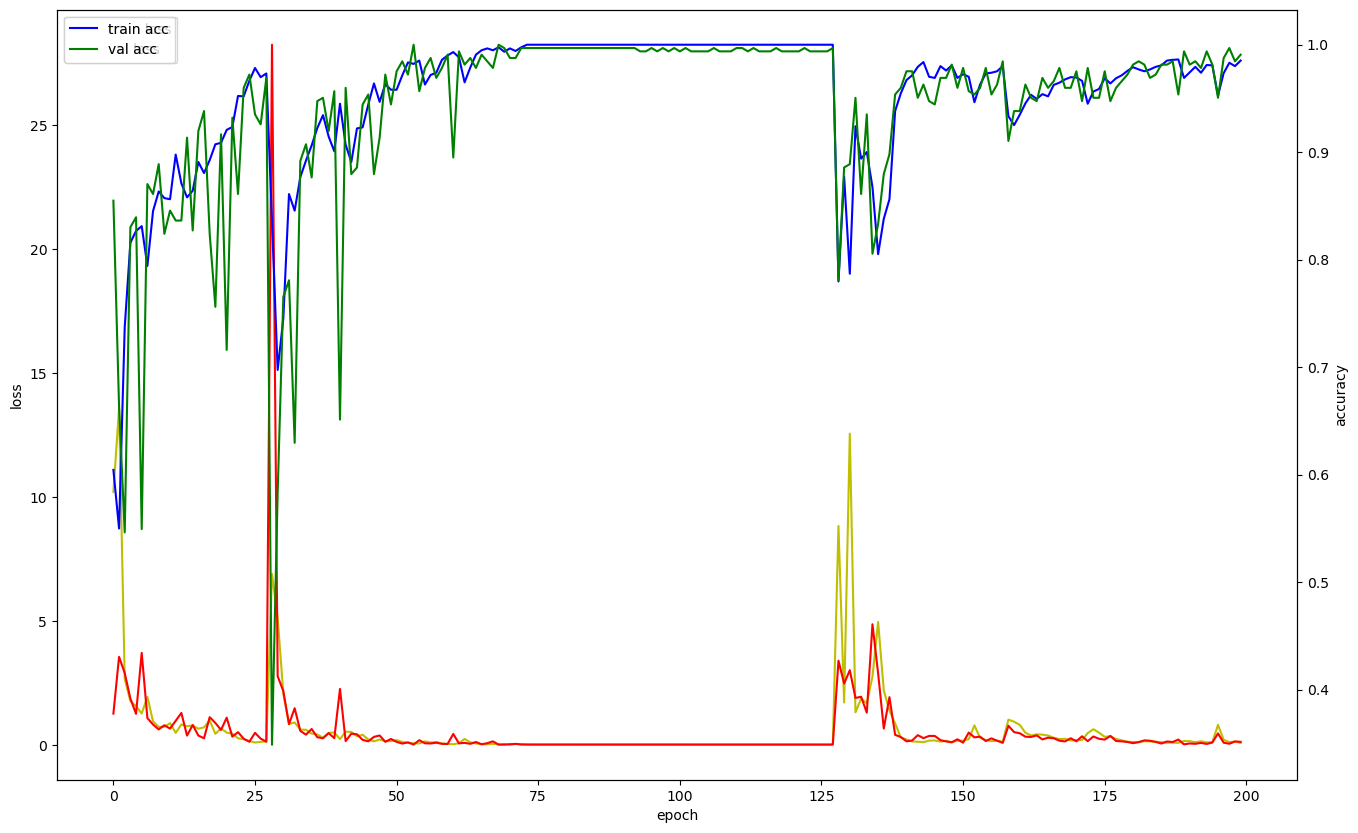

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[[217,   0],
        [  0, 107]],

       [[214,   0],
        [  0, 110]],

       [[277,   0],
        [  0,  47]],

       [[264,   0],
        [  0,  60]]], dtype=int64)